In [10]:
import numpy as np 
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


## Домашнее задание Функции потерь и оптимизация
Преподаватель: Алексей Миронов, Наталья Баданина, Дарья Максимова

Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/

Реализовать самостоятельно логистическую регрессию

Обучить ее методом градиентного спуска

Методом nesterov momentum

Методом rmsprop

В качестве dataset’а взять Iris, оставив 2 класса:

Iris Versicolor

Iris Virginica

In [11]:
iris = datasets.load_iris()
target_names = list(iris['target_names'])
target_names

['setosa', 'versicolor', 'virginica']

In [12]:
iris = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                     columns=iris['feature_names'] + ['target'])

iris.target = iris.target.apply(lambda x : target_names[int(x)])

iris = iris[iris.target != 'setosa']
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor


In [29]:
x = iris.iloc[:,:-1].values
y = iris.iloc[:,-1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [36]:
# Для чистоты эксперимента разобьем на две выборки, 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)


In [37]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [282]:
class GDLogisticRegression():
    
    def __init__(self, random_state=42):

        self.x = None
        self.y = None
        self.w = None
        self.fitted = False
        self.norm = True
        self.grads = None
        self.moving_grad = None
        self.random_state = random_state
        self.fit_history = pd.DataFrame(columns=['epoch', 'loss', 'score', 'weights', 'grads'], )

    def sigmoid(self, x):    

        return 1 / (1 + np.exp(-x))
    
    def grad(self, w):

        w = self.w

        return np.dot(np.c_[self.x, np.ones(self.x.shape[0])].T, (self.predict(self.x) - self.y)) / self.y.size
    
    def loss_func(self, w, eps=1e-15, beta=1e-9):

        y_pred = self.predict(self.x)
        y_pred = np.clip(y_pred, eps, 1 - eps)
        loss = - (self.y * np.log(y_pred + beta) + (1 - self.y) * np.log(1 - y_pred + beta))

        return loss.sum()
    
    def GD(self):
        if self.w is None:
            self.w = self.init_weights()
        self.grads = self.grad(self.w)
        self.w -= self.lr * self.grads

    def NAG(self):
        if self.w is None:
            self.w = self.init_weights()
        self.grads = self.grad(self.w)
        # self.w = self.gamma * self.w - (1 - self.gamma) * self.lr * self.grads
        self.w = self.gamma * self.w - self.lr * self.grads

    def RMSP(self):
        if self.w is None:
            self.w = self.init_weights()

        self.moving_grad = self.gamma * self.moving_grad + (1 - self.gamma) * self.grad(self.w) ** 2
        RMS = (self.moving_grad + self.eta) ** 0.5
        self.grads = self.grad(self.w)
        self.w = self.w - self.lr * self.grads / RMS
     
    def init_weights(self, how='random'):
        
        if how == 'random':
            return np.random.uniform(-1, 1, size=self.x.shape[1] + 1)
        if how == 'zeros':
            return np.zeros(size=self.x.shape[1] + 1)
        if how == 'ones':
            return np.ones(self.x.shape[1] + 1)
    
    def predict(self, x, activation='sigmoid'):

        if self.norm:
            scaler = StandardScaler()
            x = scaler.fit_transform(x)
        else:
            x = x

        self.x = x

        if x.ndim == 1:
            x = x[np.newaxis, :]
     
        if self.w is None:
            self.w = self.init_weights()

        x = np.c_[x, np.ones(x.shape[0])]

        if activation == 'sigmoid':
            return self.sigmoid(x @ self.w)
        else:
            return x @ self.w
    
    def fit(self, x, y, lr=0.1, optimizer='GD', epoch=2000, norm=True, verbose=None, gamma=0.9, eta=1e-8):
        '''
        optimizer:
        'GD' - Gradient Descent
        'NAG' - Nesterov Accelerated Gradient, parameter -  gamma
        'RMSP' - RMSProp parameter -  gamma, eta
        '''
        self.x = np.c_[x, np.ones(x.shape[0])]
        self.lr = lr
        self.fitted = True
        self.norm = norm
        self.gamma = gamma
        self.moving_grad = np.zeros(x.shape[1] + 1) + 0.01
        self.eta = eta


        if norm:
            scaler = StandardScaler()
            self.x = scaler.fit_transform(x)
        else:
            self.x = x
        
        if y.dtype != 'int':
            le = LabelEncoder()
            self.y = le.fit_transform(y)
        else:
            self.y = y
            
        if optimizer == 'GD':
            optimize = self.GD
        
        if optimizer == 'NAG':
            optimize = self.NAG
            
        if optimizer == 'RMSP':
            optimize = self.RMSP

        print(f'Training start! optimizer: {optimizer}')

        for epoch in range(epoch):

            optimize()

            self.fit_history.loc[epoch] = {'epoch': epoch, 'loss': self.loss_func(self.w),
                                           'score': accuracy_score(self.predict(self.x)>0.5, self.y),
                                           'weights': self.w, 
                                           'grads': self.grads,
                                           }
            if verbose:
                if epoch % verbose == 0:
                    print(f'epoch {epoch}: loss = {self.loss_func(self.w):.2f}, score = {self.score(self.predict(self.x)>0.5, self.y)}')
        
        self.w = self.fit_history.iloc[self.fit_history.score.argmax()].weights
        print(f'Training stop: loss = {self.loss_func(self.w):.2f}, score = {self.score(self.predict(self.x)>0.5, self.y)}')

    def score(self, x=None, y=None):
        if (x is None) and (y is None):
            x = self.predict(self.x)
            y = self.y

        return accuracy_score(x>0.5, y)

    def plot_history(self):
            sns.set(style="whitegrid")
            fig, ax =plt.subplots(1,2, figsize=(20,8))
            sns.lineplot(data=self.fit_history, x='epoch', y='loss', ax=ax[0]).set(title=f"loss function (min loss = {self.fit_history.loss.min():.2f})")
            sns.lineplot(data=self.fit_history, x='epoch', y='score', ax=ax[1]).set(title=f"score (max score = {self.fit_history.score.max():.2f})")
            fig.show()


Training start! optimizer: GD
epoch 0: loss = 73.78, score = 0.45
epoch 300: loss = 10.75, score = 0.975
Training stop: loss = 9.15, score = 0.9625
model score test = 1.0


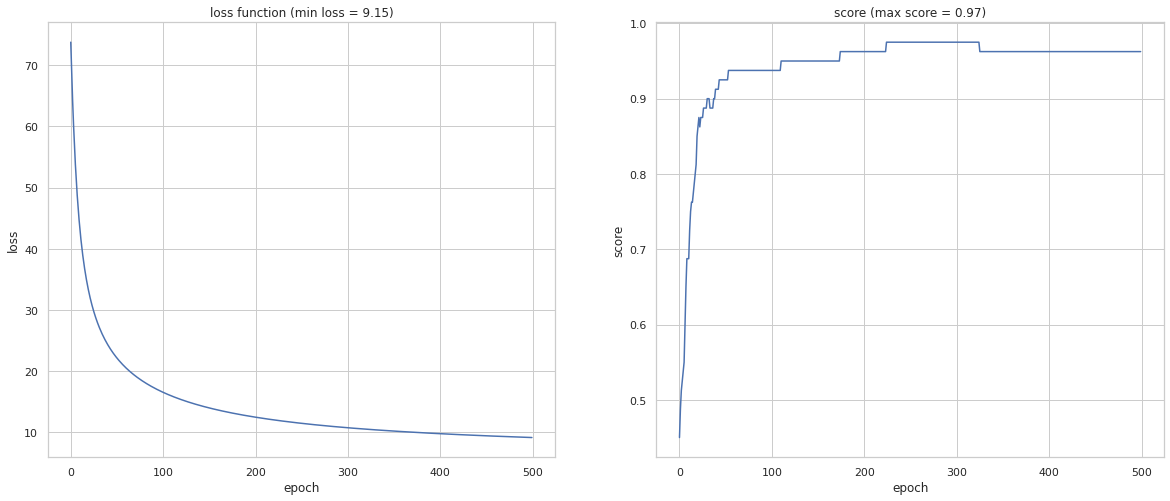

In [283]:
# Gradiend Desent
model = GDLogisticRegression()
model.fit(X_train, y_train, lr=0.11, verbose=300, epoch=500)
print(f'model score test = {model.score(model.predict(X_test), y_test)}')
model.plot_history()

Training start! optimizer: NAG
epoch 0: loss = 76.18, score = 0.125
epoch 300: loss = 21.77, score = 0.9375
epoch 600: loss = 21.70, score = 0.9375
epoch 900: loss = 21.70, score = 0.9375
epoch 1200: loss = 21.70, score = 0.9375
epoch 1500: loss = 21.70, score = 0.9375
epoch 1800: loss = 21.70, score = 0.9375
Training stop: loss = 24.69, score = 0.95
model score test = 1.0


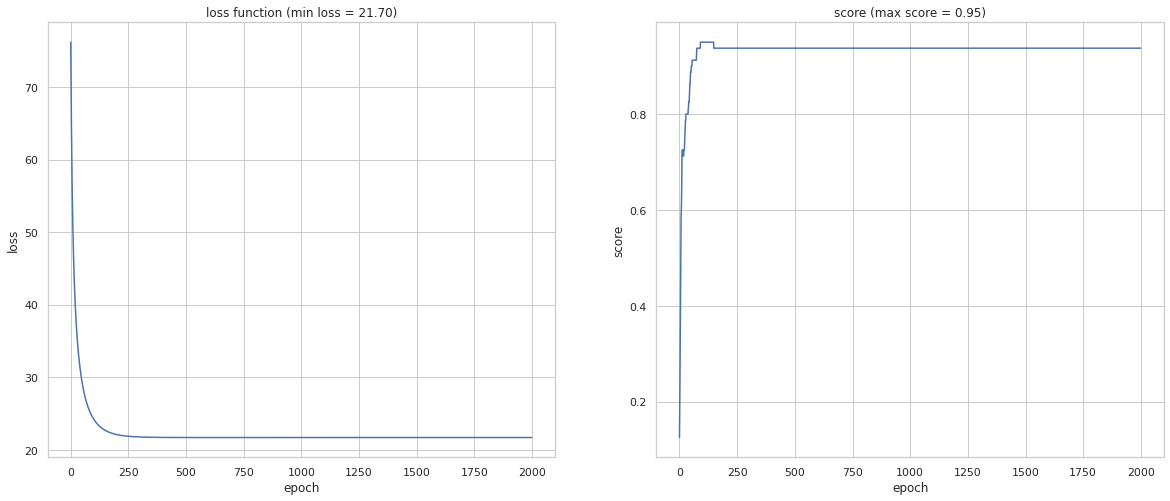

In [302]:
# Nesterov Accelerated Gradient
model = GDLogisticRegression()
model.fit(X_train, y_train, lr=0.10, epoch=2000, optimizer='NAG', verbose=300, gamma=0.99)
print(f'model score test = {model.score(model.predict(X_test), y_test)}')
model.plot_history()

Training start! optimizer: RMSP
epoch 0: loss = 98.82, score = 0.3
epoch 300: loss = 9.49, score = 0.9875
epoch 600: loss = 6.22, score = 0.975
epoch 900: loss = 5.94, score = 0.975
epoch 1200: loss = 5.94, score = 0.975
epoch 1500: loss = 5.94, score = 0.975
epoch 1800: loss = 5.94, score = 0.975
Training stop: loss = 13.75, score = 0.9875
model score test = 1.0


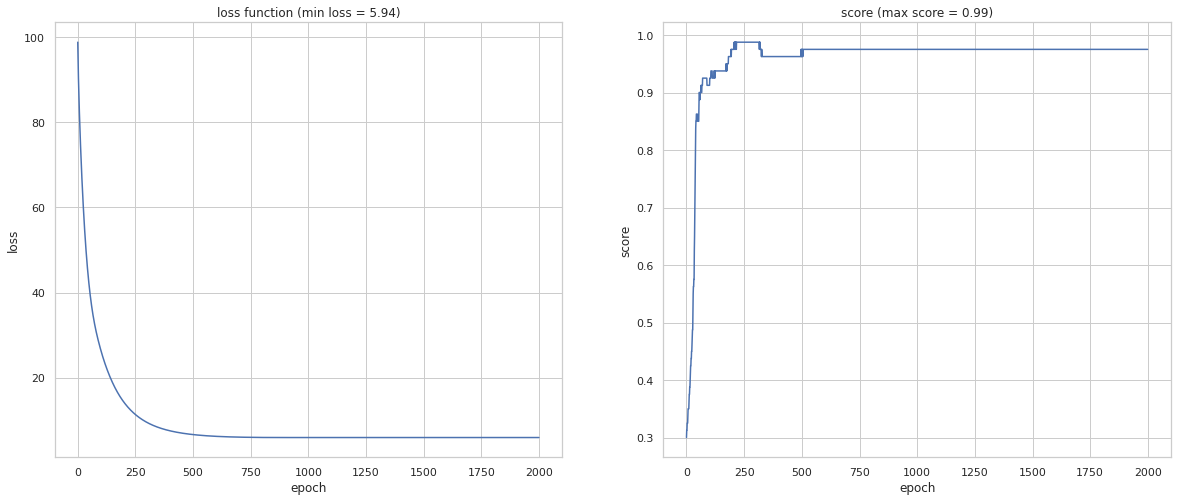

In [291]:
# RMSProp
model = GDLogisticRegression()
model.fit(X_train, y_train, lr=0.01, epoch=2000, optimizer='RMSP', verbose=300, gamma=0.9, eta=1e-9)
print(f'model score test = {model.score(model.predict(X_test), y_test)}')
model.plot_history()

### Существенных различий в приросте качества обучения среди реализованных алготитмов не наблюдается

### Gradiend Desent
Достаточно стабильно и предсказуемо позволяет минимизировать функцию потерь

### Nesterov Accelerated Gradient
Чувствуется инерция при обучении, часто выходит из зон локальных минимумов, которые в оказались с меньшими значениями функции потерь, чем в тех минимумах, которые от достиг в последствии

Т.е "выкатывается" из более глубоких локальных минимумов

### RMSProp
Достаточно стабилен, менее чувствителен к скорости обучения, позволил достигнуть максимального значения метрики